Encontradas 86437 imagens
Dispositivo: cuda
Iniciando validação cruzada com 5 folds...

Treinando Fold 1/5
Fold 1 | Epoch 1/5
Train Loss: 1.2600 | Val Loss: 0.9336
Acc: 0.5127 | Prec: 0.3207 | Recall: 0.3722 | F1-macro: 0.2899
------------------------------------------------------------
Fold 1 | Epoch 2/5
Train Loss: 1.0893 | Val Loss: 0.8802
Acc: 0.5805 | Prec: 0.3340 | Recall: 0.4249 | F1-macro: 0.3158
------------------------------------------------------------
Fold 1 | Epoch 3/5
Train Loss: 0.9581 | Val Loss: 0.9630
Acc: 0.5789 | Prec: 0.3634 | Recall: 0.6432 | F1-macro: 0.3560
------------------------------------------------------------
Fold 1 | Epoch 4/5
Train Loss: 0.8263 | Val Loss: 0.8799
Acc: 0.6124 | Prec: 0.4406 | Recall: 0.6526 | F1-macro: 0.4659
------------------------------------------------------------
Fold 1 | Epoch 5/5
Train Loss: 0.7398 | Val Loss: 0.4895
Acc: 0.7757 | Prec: 0.6324 | Recall: 0.6593 | F1-macro: 0.6313
-------------------------------------------------

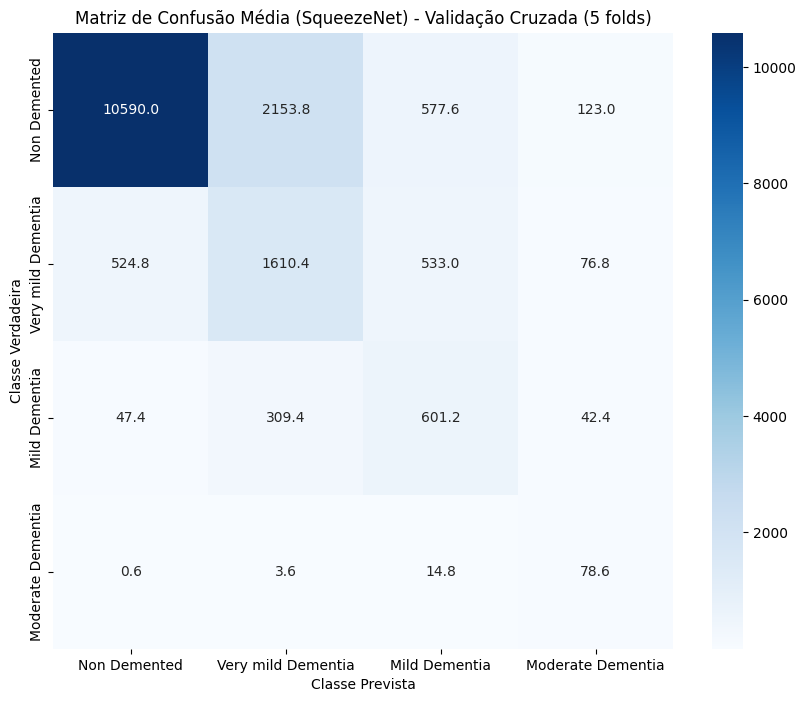

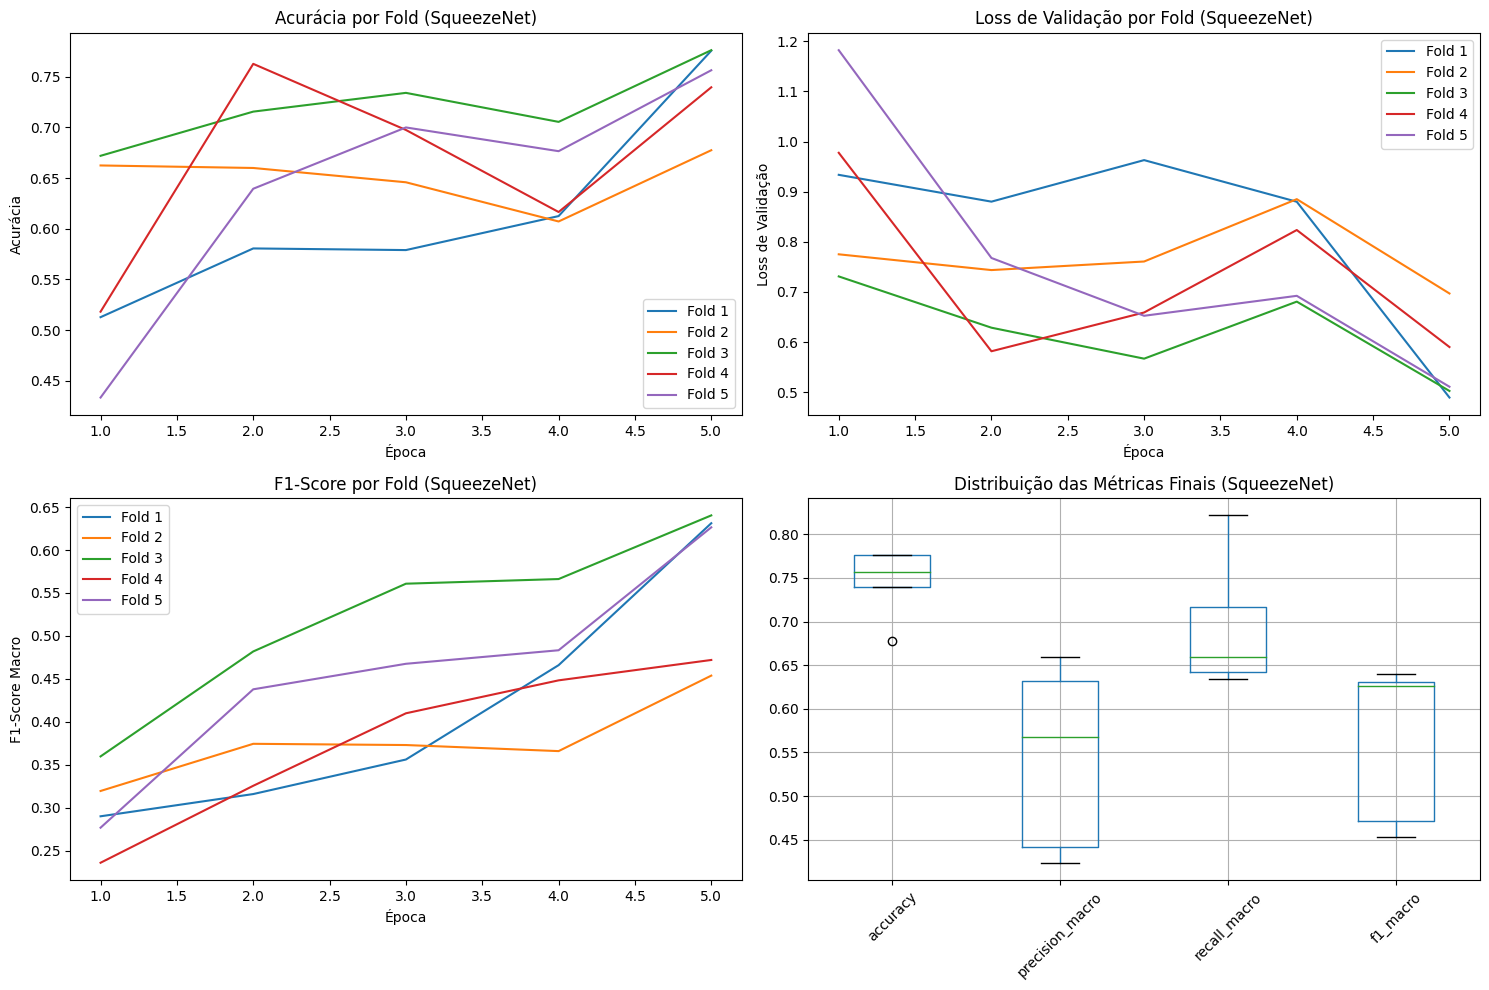

In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import polars as pl
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap

# ============================================================
# Download do dataset OASIS via kagglehub
# ============================================================
path = kagglehub.dataset_download("ninadaithal/imagesoasis")
data_path = Path(path) / "Data"

# Coletar paths das imagens usando Polars
image_paths = []
for p in data_path.rglob('*.*'):
    if p.is_file():
        parts = p.parts
        if len(parts) >= 2:
            class_name = parts[-2]
            file_name = parts[-1]
            image_paths.append((class_name, file_name, str(p)))

print(f"Encontradas {len(image_paths)} imagens")

# Criar DataFrame Polars
df = pl.DataFrame({
    'class': [x[0] for x in image_paths],
    'image': [x[1] for x in image_paths],
    'path': [x[2] for x in image_paths]
})

# Salvar metadados
output_path = "oasis_dataset_metadata.parquet"
df.write_parquet(output_path)

# ============================================================
# Configurações
# ============================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

# Transformações
transform = transforms.Compose([
    transforms.Resize((248, 496)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Dataset personalizado
class OASISDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.class_to_idx = {
            'Non Demented': 0,
            'Very mild Dementia': 1,
            'Mild Dementia': 2,
            'Moderate Dementia': 3
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.row(idx)
        img_path = row[2]
        class_name = row[0]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.class_to_idx[class_name]
        return image, label

# ============================================================
# Modelo seguro para SHAP (SqueezeNet)
# ============================================================
class SafeSqueezeNet(nn.Module):
    def __init__(self, num_classes=4):
        super(SafeSqueezeNet, self).__init__()
        self.squeezenet = models.squeezenet1_0(weights=None)

        # Corrigir in-place ReLU
        for m in self.squeezenet.modules():
            if isinstance(m, nn.ReLU):
                m.inplace = False

        # Ajustar camada final para número de classes
        self.squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        self.squeezenet.num_classes = num_classes

    def forward(self, x):
        return self.squeezenet(x)

# ============================================================
# Validação Cruzada K-Fold
# ============================================================
def train_model(train_loader, val_loader, fold, num_epochs=5):
    """Função para treinar um modelo em um fold específico"""

    # Modelo
    model = SafeSqueezeNet(num_classes=4).to(device)

    # Loss function com pesos
    class_weights = torch.tensor([0.3215, 1.5744, 4.3201, 44.2812], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    fold_metrics = []

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        # Estatísticas
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)

        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        epoch_time = time.time() - epoch_start

        print(f'Fold {fold+1} | Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Acc: {acc:.4f} | Prec: {prec:.4f} | Recall: {rec:.4f} | F1-macro: {f1:.4f}')
        print('-' * 60)

        fold_metrics.append({
            "fold": fold+1,
            "epoch": epoch+1,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "accuracy": acc,
            "precision_macro": prec,
            "recall_macro": rec,
            "f1_macro": f1,
            "epoch_time_sec": epoch_time
        })

        scheduler.step()

    return fold_metrics, all_labels, all_preds, model

# ============================================================
# Executar Validação Cruzada
# ============================================================
df = pl.read_parquet("oasis_dataset_metadata.parquet")
dataset = OASISDataset(df, transform=transform)

# Configuração K-Fold
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

all_metrics = []
all_confusion_matrices = []
best_models = []

print(f"Iniciando validação cruzada com {k_folds} folds...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
    print(f"\n{'='*50}")
    print(f"Treinando Fold {fold+1}/{k_folds}")
    print(f"{'='*50}")

    # Criar subsets para este fold
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    # Treinar modelo
    fold_metrics, val_labels, val_preds, model = train_model(
        train_loader, val_loader, fold, num_epochs=5
    )

    # Guardar resultados
    all_metrics.extend(fold_metrics)

    # Matriz de confusão para este fold
    cm = confusion_matrix(val_labels, val_preds)
    all_confusion_matrices.append(cm)

    # Salvar o melhor modelo deste fold
    torch.save(model.state_dict(), f'squeezenet_fold_{fold+1}_best.pth')
    best_models.append(model)

    print(f"Fold {fold+1} concluído!")

# ============================================================
# Análise dos Resultados da Validação Cruzada
# ============================================================

# Salvar todas as métricas
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv("squeezenet_cross_validation_metrics.csv", index=False)
print("Métricas de validação cruzada salvas!")

# Estatísticas agregadas por fold
fold_summary = metrics_df.groupby('fold').agg({
    'accuracy': 'max',
    'f1_macro': 'max',
    'val_loss': 'min'
}).reset_index()

print("\n" + "="*60)
print("RESUMO DA VALIDAÇÃO CRUZADA")
print("="*60)
print(fold_summary)

print(f"\nAcurácia média: {fold_summary.accuracy.mean():.4f} ± {fold_summary.accuracy.std():.4f}")
print(f"F1-Score médio: {fold_summary.f1_macro.mean():.4f} ± {fold_summary.f1_macro.std():.4f}")
print(f"Loss de validação média: {fold_summary.val_loss.mean():.4f} ± {fold_summary.val_loss.std():.4f}")

# Matriz de confusão média
mean_cm = np.mean(all_confusion_matrices, axis=0)
std_cm = np.std(all_confusion_matrices, axis=0)

print("\nMatriz de Confusão Média:")
print(mean_cm.astype(int))
print("\nDesvio Padrão da Matriz de Confusão:")
print(std_cm.astype(int))

# Salvar matriz de confusão média
np.save("squeezenet_mean_confusion_matrix.npy", mean_cm)
np.save("squeezenet_std_confusion_matrix.npy", std_cm)

# Plot da matriz de confusão média
class_names = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

plt.figure(figsize=(10, 8))
sns.heatmap(mean_cm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe Prevista')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão Média (SqueezeNet) - Validação Cruzada (5 folds)')
plt.savefig('squeezenet_cross_validation_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot da evolução das métricas por fold
plt.figure(figsize=(15, 10))

# Acurácia por fold
plt.subplot(2, 2, 1)
for fold in range(k_folds):
    fold_data = metrics_df[metrics_df['fold'] == fold+1]
    plt.plot(fold_data['epoch'], fold_data['accuracy'], label=f'Fold {fold+1}')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Acurácia por Fold (SqueezeNet)')
plt.legend()

# Loss por fold
plt.subplot(2, 2, 2)
for fold in range(k_folds):
    fold_data = metrics_df[metrics_df['fold'] == fold+1]
    plt.plot(fold_data['epoch'], fold_data['val_loss'], label=f'Fold {fold+1}')
plt.xlabel('Época')
plt.ylabel('Loss de Validação')
plt.title('Loss de Validação por Fold (SqueezeNet)')
plt.legend()

# F1-Score por fold
plt.subplot(2, 2, 3)
for fold in range(k_folds):
    fold_data = metrics_df[metrics_df['fold'] == fold+1]
    plt.plot(fold_data['epoch'], fold_data['f1_macro'], label=f'Fold {fold+1}')
plt.xlabel('Época')
plt.ylabel('F1-Score Macro')
plt.title('F1-Score por Fold (SqueezeNet)')
plt.legend()

# Boxplot das métricas finais
plt.subplot(2, 2, 4)
final_metrics = metrics_df.groupby('fold').tail(1)
metrics_to_plot = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
final_metrics[metrics_to_plot].boxplot()
plt.title('Distribuição das Métricas Finais (SqueezeNet)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('squeezenet_cross_validation_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()